full tut: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

### Deal with data
* Hình ảnh: openCV, torchvision
* Audio: scipy, librosa
* text:  NLTK, SpaCy

Tiếp theo đây dùng torchvision để tải tập dữ liệu CIFAR10 và chuẩn hóa (normalize)

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].  

Khai báo 1 biến transform dùng để transform dữ liệu, compose 2 thứ:
+ chuyển dữ liệu về tensor trong torch
+ normalize về [-1, 1] từ ban đầu là [0, 1], thật vậy pixel_value = (pixel_value - mean) / std, (1-0.5)/0.5 = 1. (0-0.5)/0.5 = -1  
ở đây có 3 lần 0.5 là vì có 3 kênh màu

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

print(transform)

Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)


#### Tải dữ liệu

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


* trainset sẽ là list 50000 tupple  
* 1 tupple sẽ bao gồm 1 tensor 3x32x32 (giá trị ảnh) và 1 nhãn  
* trainloader sẽ gồm nhiều thứ hơn (dataset, batch_size, ...) 
https://pytorch.org/docs/stable/_modules/torch/utils/data/dataloader.html

num_workers > 0 is used to preprocess batches of data so that the next batch is ready for use when the current batch has been finished. More num_workers would consume more memory usage but is helpful to speed up the I/O process

In [64]:
print(len(trainset))
print(trainset[0][0].shape)
print(trainloader.dataset) # same as trainset
print(testset)

for data in testloader:
    print(data)
    break

50000
torch.Size([3, 32, 32])
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
[tensor([[[[ 0.2392,  0.2471,  0.2941,  ...,  0.0745, -0.0118, -0.0902],
          [ 0.1922,  0.1843,  0.2471,  ...,  0.0667, -0.0196, -0.0667],
          [ 0.1843,  0.1843,  0.2392,  ...,  0.0902,  0.0196, -0.0588],
          ...,
          [-0.4667, -0.6706, -0.7569,  ..., -0.7020, -0.8980, -0.6863],
          [-0.5216, -0.6157, -0.7255,  ..., -0.7961, -0.7725, -0.8431],
          [-0.5765, -0.5608, -0.6471,  ..., -0.8118, -0.7333, -0.8353]],

         [[-0.1216, -0.1294, -0.0902,  ..., -0.2549, -0.2863, -0.3333],
          [-0.1216, -0.1373, -0.1059,  ..., -0.2549, -0.2863, -0.3098],
          [-0.1373, -0.1451, -0.1294,  ..., -0.2314, -0.2549, -0.3020],
          ...,
          [-0.0275, -0.2157, -0.3098,  ..., -0.2392, -0.4980, -0.3333],
          [-0.0902, -0.2000, -0.3333

#### Show dữ liệu kiểm tra thử
torchvision.utils.make_grid: display nhiều hình thành 1 cái grid, như ở dưới là 4 hình

4
tensor([9])
image torch torch.Size([3, 36, 138])
image numpy (3, 36, 138)


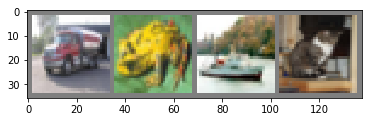

truck  frog  ship   cat


In [24]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print('image torch', img.shape)  # 3x36x138
    print('image numpy', npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # 36x138x3 
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()  # images and labels in 1 batch

print(len(images))
print(labels[:1])

# show images
imshow(torchvision.utils.make_grid(images))
plt.show()
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#### Khai báo 1 CNN

In [25]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 3 input channels, 6 output channels, 5x5 conv
        self.pool = nn.MaxPool2d(2, 2)  # 2 x 2 maxpool window
        self.conv2 = nn.Conv2d(6, 16, 5)  # 6 input channels, 16 output channels, 5x5 conv
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # weight giữa fc1 và fc2
        self.fc2 = nn.Linear(120, 84)  # tương tự
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # ReLU as activation function
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

#### Loss function

In [26]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# stochastic gradient descent to update net 's parameters
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 

#### Training
* enumerate là để lấy index trong khi iter kiểu dùng in

Since the backward() function accumulates gradients, and you don’t want to mix up gradients between minibatches, you have to zero them out at the start of a new minibatch

In [31]:
for epoch in range(2):  # loop over the dataset multiple times (2 epochs)

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data  # inputs.shape: batch_size x 3 x 32 x 32\
        
        # zero the parameter gradients
        optimizer.zero_grad()  # zero the gradient buffers

        # forward + backward + optimize
        outputs = net(inputs)  #  outputs.shape: batch_size x num_class
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.211
[1,  4000] loss: 1.912
[1,  6000] loss: 1.721
[1,  8000] loss: 1.637
[1, 10000] loss: 1.572
[1, 12000] loss: 1.519
[2,  2000] loss: 1.469
[2,  4000] loss: 1.431
[2,  6000] loss: 1.394
[2,  8000] loss: 1.389
[2, 10000] loss: 1.370
[2, 12000] loss: 1.370
Finished Training


#### show some test case

image torch torch.Size([3, 36, 138])
image numpy (3, 36, 138)


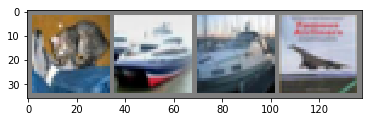

Ground truth:    cat  ship  ship plane
Predict:    cat  ship  ship  ship


In [65]:
test_iter = iter(testloader)
test_imgs, labels = test_iter.next()

imshow(torchvision.utils.make_grid(test_imgs))
print('Ground truth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

test_outs = net(test_imgs)
max_pred = torch.max(test_outs, 1)  # axis = 1
# print(max_pred)
max_pred = max_pred.indices.numpy()

print('Predict: ', ' '.join('%5s' % classes[max_pred[j]] for j in range(4)))

#### Test on testset

In [69]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        # print(predicted, labels) for example: tensor([3, 8, 8, 8]) tensor([3, 8, 8, 0])
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


In [70]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 60 %
Accuracy of   car : 55 %
Accuracy of  bird : 31 %
Accuracy of   cat : 36 %
Accuracy of  deer : 49 %
Accuracy of   dog : 52 %
Accuracy of  frog : 68 %
Accuracy of horse : 55 %
Accuracy of  ship : 63 %
Accuracy of truck : 59 %


#### train on gpu
Đưa các parameters và các input vào devices

In [72]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [76]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [79]:
inputs, labels = data[0].to(device), data[1].to(device)